    프로야구 선수의 다음해 연봉 예측하기

In [3]:
# 회귀분석 : 실제 데이터와 거리가 최소가 되는 방정식을 찾아내는 것
# 지도 학습 : 학습 전용 데이터셋-> 테스트 전용 데이터 셋을 구하는 과정

# 학습 전용 데이터 셋 : 주어진 조건
# 테스트 전용 데이터 셋 : 구하고 싶은 데이터

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 폰트 찾기
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

#Data Source : http://www.statiz.co.kr/
pitcher_file_path = 'data/picher_stats_2017.csv'
batter_file_path = 'data/batter_stats_2017.csv'
pitcher = pd.read_csv(pitcher_file_path)
batter=pd.read_csv(batter_file_path)

pitcher.columns

Index(['선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)'],
      dtype='object')

In [5]:
pitcher.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000


In [6]:
print(pitcher.shape)

(152, 22)


In [7]:
pitcher['연봉(2018)'].describe()

count       152.000000
mean      18932.236842
std       30940.732924
min        2700.000000
25%        4000.000000
50%        7550.000000
75%       18500.000000
max      230000.000000
Name: 연봉(2018), dtype: float64

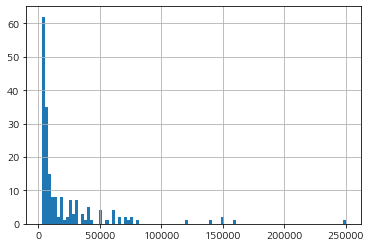

In [8]:
batter['연봉(2018)'].hist(bins=100) # 2018년 연봉 분포를 출력합니다. bins는 막대의 너비

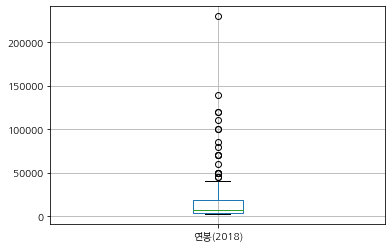

In [9]:
pitcher.boxplot(column=['연봉(2018)']) # WAR의 상자그림을 출력합니다.

In [10]:
pitcher_features_df=pitcher[['승','패','세','홀드', '블론', '경기','선발','이닝','삼진/9','볼넷/9','홈런/9', 'BABIP','LOB%',
                            'ERA','RA9-WAR','FIP', 'kFIP', 'WAR', '연봉(2018)', '연봉(2017)']]

#피처 각각에 대한 히스토그램을 출력
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize']=[20,16]
    fig=plt.figure(1)
    
    # df의 열 개수만큼의 subplot을 출력합니다.
    for i in range(len(df.columns)):
        ax=fig.add_subplot(5,5,i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
    plt.show()

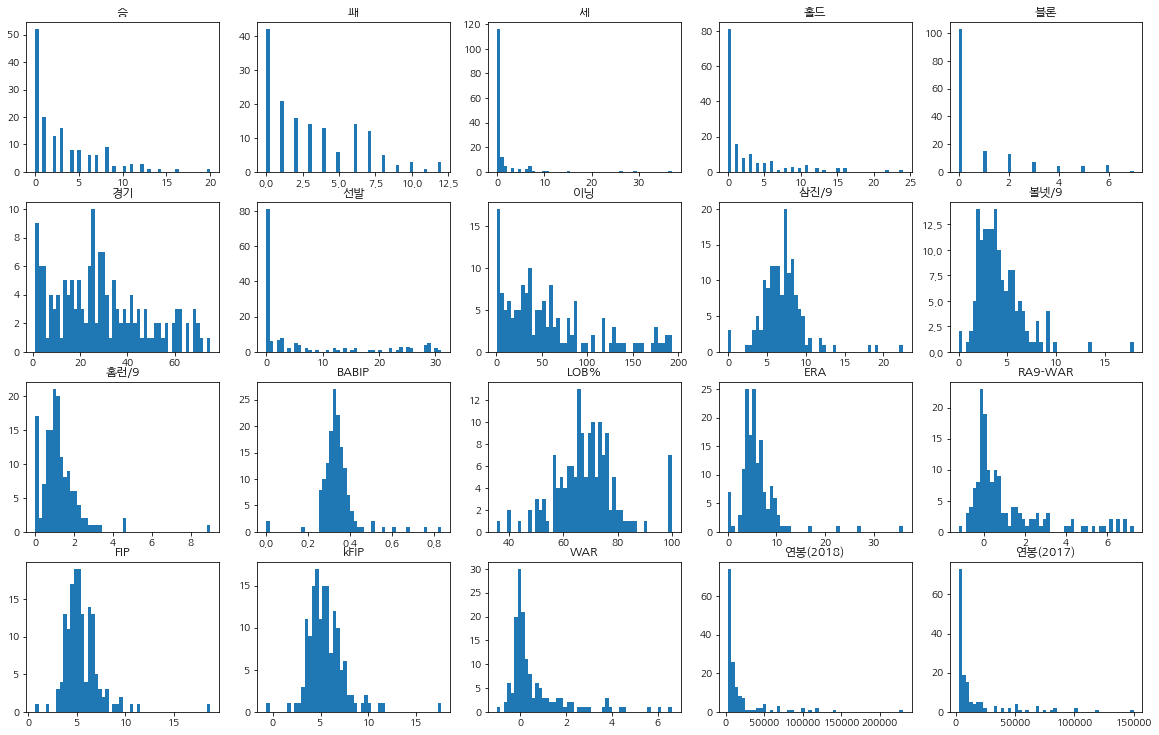

In [11]:
plot_hist_each_column(pitcher_features_df)

    피치의 정규화(피치 스케일링) : 회귀분석에서 영향도에 따라 상대적 값을 표현해주는 정규화과정
    
    # 투수들의 연봉 예측하기

In [12]:
# 판다스 형태로 정의된 데이터를 출력할 때 scientific-notation이 아닌 float모양으로 출력되게 해줍니다.
pd.options.mode.chained_assignment = None

In [13]:
# 피처 각각에 대한 스케일일을 수행하는 함수를 정의합니다.
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean=df[col].mean()
        series_std=df[col].std()
        df[col]=df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

In [14]:
# 피처 각각에 대한 스케일링을 수행합니다.
scale_columns = ['승','패','세','홀드','블론','경기','선발','이닝','삼진/9','볼넷/9','홈런/9','BABIP','LOB%','ERA',
                 'RA9-WAR','FIP','kFIP', 'WAR','연봉(2017)']
pitcher_df = standard_scaling(pitcher, scale_columns)
pitcher_df = pitcher_df.rename(columns={'연봉(2018)':'y'})
pitcher_df.head(10)

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,y,연봉(2017)
0,켈리,SK,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,...,-0.442382,0.016783,0.446615,-0.587056,3.174630,-0.971030,-1.058125,4.503142,140000,2.734705
1,소사,LG,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,...,-0.668521,-0.241686,-0.122764,-0.519855,3.114968,-1.061888,-1.073265,4.094734,120000,1.337303
2,양현종,KIA,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,...,-0.412886,-0.095595,0.308584,-0.625456,2.973948,-0.837415,-0.866361,3.761956,230000,5.329881
3,차우찬,LG,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,...,-0.186746,-0.477680,0.558765,-0.627856,2.740722,-0.698455,-0.760385,2.998081,100000,3.333592
4,레일리,롯데,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,...,-0.294900,-0.196735,0.481122,-0.539055,2.751570,-0.612941,-0.619085,2.809003,111000,2.734705
5,피어밴드,KT,1.243035,2.185327,-0.306452,-0.585705,-0.543592,-0.147055,2.041816,2.048726,...,-0.088425,-0.578820,0.653661,-0.721456,2.963100,-0.580874,-0.614039,2.476226,85000,0.738417
6,고영표,KT,1.243035,2.824115,-0.306452,-0.364245,-0.543592,-0.198678,1.836690,1.674951,...,-0.373557,0.241539,-0.338437,-0.231854,1.037633,-0.869482,-0.886546,2.423284,11500,-0.451371
7,장원준,두산,2.795976,1.865933,-0.306452,-0.585705,-0.543592,0.007811,2.349505,2.448347,...,-0.599696,-0.533869,0.627780,-0.697456,3.375313,-0.666387,-0.598899,2.408158,100000,3.333592
8,함덕주,두산,1.501858,1.546539,-0.306452,-0.142784,-0.543592,0.317545,1.836690,1.593436,...,-0.678353,-0.219211,0.394853,-0.570256,2.133251,-0.853448,-0.942057,2.355216,16000,-0.379505
9,팻딘,KIA,1.501858,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.349505,2.366832,...,-0.088425,0.140398,0.688169,-0.457455,2.496649,-0.457948,-0.467692,2.249332,70000,2.135819


In [15]:
# 피처들의 단위 맞춰주기
# 팀명 피처를 원-핫 인코딩으로 변환합니다. -> get_dummies()
team_encoding=pd.get_dummies(pitcher_df['팀명'])
pitcher_df=pitcher_df.drop('팀명',axis=1)
pitcher_df=pitcher_df.join(team_encoding)
team_encoding.head(5)

,KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


In [16]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 학습 데이터와 테스트 데이터로 분리합니다.
#(X_train, y_train): (X_test, y_test) = 8:2 비율(test_size)로 4개의 테스트가 생성
X = pitcher_df[pitcher_df.columns.difference(['선수명','y'])]
y = pitcher_df['y']
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=19)

In [17]:
# 회귀 분석 계수를 학습합니다. (회귀모델학습)
lr=linear_model.LinearRegression() # 모델 오브젝트
model=lr.fit(X_train, y_train) #모델 오브젝트에 기반한 학습

# 학습된 계수를 출력합니다.
print(lr.coef_)

[ -1481.01733901   -416.68736601 -94136.23649209  -1560.86205158
   1572.00472193   -747.04952389  -1375.53830289   -523.54687556
   3959.10653661    898.37638984  10272.48746451  77672.53804469
  -2434.38947427   -892.11801281    449.91117164   7612.15661812
   1271.04500059  -2810.5564514    5396.97279896  -4797.30275904
   -250.69773139    236.02530053  19130.59021357    854.02604585
   1301.61974637   3613.84063182   -935.07281796  18144.60099745]


In [18]:
# 어떤 피처가 가장 영향력 있는 피처일까
import statsmodels.api as sm
# statmodel 라이브러리로 회귀 분석을 수행합니다.
X_train = sm.add_constant(X_train)
model=sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     44.19
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           7.70e-42
Time:                        14:42:27   Log-Likelihood:                -1247.8
No. Observations:                 121   AIC:                             2552.
Df Residuals:                      93   BIC:                             2630.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.678e+04    697.967     24.036      0.000    1.54e+04    1.82e+04
BABIP      -1481.0173   1293.397     -1.145      0.255   -4049.448    1087.414
ERA         -416.6874   2322.402     -0.179      0.858   -5028.517    4195.143
FIP        -9.414e+04   9.43e+04     -0.998      0.321   -2.81e+05    9.31e+04
KIA          303.1852   2222.099      0.136      0.892   -4109.462    4715.833
KT          3436.0520   2133.084      1.611      0.111    -799.831    7671.935
LG          1116.9978   2403.317      0.465      0.643   -3655.513    5889.509
LOB%       -1375.5383   1564.806     -0.879      0.382   -4482.933    1731.857
NC          1340.5004   2660.966      0.504      0.616   -3943.651    6624.652
RA9-WAR     3959.1065   2931.488      1.351      0.180   -1862.247    9780.460
SK          2762.4237   2243.540      1.231      0.221   -1692.803    7217.650
WAR         1.027e+04   2532.309      4.057      0.000    5243.823    1.53e+04
kFIP        7.767e+04   7.95e+04      0.977      0.331   -8.03e+04    2.36e+05
경기         -2434.3895   2953.530     -0.824      0.412   -8299.515    3430.736
두산           971.9293   2589.849      0.375      0.708   -4170.998    6114.857
롯데          2313.9585   2566.009      0.902      0.370   -2781.627    7409.544
볼넷/9        7612.1566   6275.338      1.213      0.228   -4849.421    2.01e+04
블론          1271.0450   1242.128      1.023      0.309   -1195.576    3737.666
삼성          -946.5092   2482.257     -0.381      0.704   -5875.780    3982.762
삼진/9        5396.9728   7286.221      0.741      0.461   -9072.019    1.99e+04
선발         -4797.3028   5489.352     -0.874      0.384   -1.57e+04    6103.463
세           -250.6977   1295.377     -0.194      0.847   -2823.059    2321.663
승            236.0253   2215.264      0.107      0.915   -4163.049    4635.100
연봉(2017)    1.913e+04   1270.754     15.055      0.000    1.66e+04    2.17e+04
이닝           854.0260   6623.940      0.129      0.898   -1.23e+04     1.4e+04
패           1301.6197   1935.935      0.672      0.503   -2542.763    5146.003
한화          5477.8879   2184.273      2.508      0.014    1140.355    9815.421
홀드          -935.0728   1637.923     -0.571      0.569   -4187.663    2317.518
홈런/9        1.814e+04   1.68e+04      1.082      0.282   -1.52e+04    5.14e+04
==============================================================================
Omnibus:                       28.069   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.274
Skew:                          -0.405   Prob(JB):                     6.52e-43
Kurtosis:                       9.155   Cond. No.                     3.44e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is

In [19]:
# R-sqaured(결정계수) : 0.928 Adj.R-squared(수정된 결정계수) : 0.907
# -> 회귀분석이 얼마나 잘되었는가 평가하는 지표 1에 가까울수록 잘 되었다.
# F통계량 : p-value인 (Prob) : 005이하면 F 통계량이 유의미한 의미를 가진다
# P > |t| : 검정 통계량이 얼마나 유의미한지(t-statistics)
# WAR 연봉(2017) 한화 -> 유의미한 피처(p-value가 0.05이하)

[Text(0, 0, 'const'),
 Text(0, 0, 'BABIP'),
 Text(0, 0, 'ERA'),
 Text(0, 0, 'FIP'),
 Text(0, 0, 'KIA'),
 Text(0, 0, 'KT'),
 Text(0, 0, 'LG'),
 Text(0, 0, 'LOB%'),
 Text(0, 0, 'NC'),
 Text(0, 0, 'RA9-WAR'),
 Text(0, 0, 'SK'),
 Text(0, 0, 'WAR'),
 Text(0, 0, 'kFIP'),
 Text(0, 0, '경기'),
 Text(0, 0, '두산'),
 Text(0, 0, '롯데'),
 Text(0, 0, '볼넷/9'),
 Text(0, 0, '블론'),
 Text(0, 0, '삼성'),
 Text(0, 0, '삼진/9'),
 Text(0, 0, '선발'),
 Text(0, 0, '세'),
 Text(0, 0, '승'),
 Text(0, 0, '연봉(2017)'),
 Text(0, 0, '이닝'),
 Text(0, 0, '패'),
 Text(0, 0, '한화'),
 Text(0, 0, '홀드'),
 Text(0, 0, '홈런/9')]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


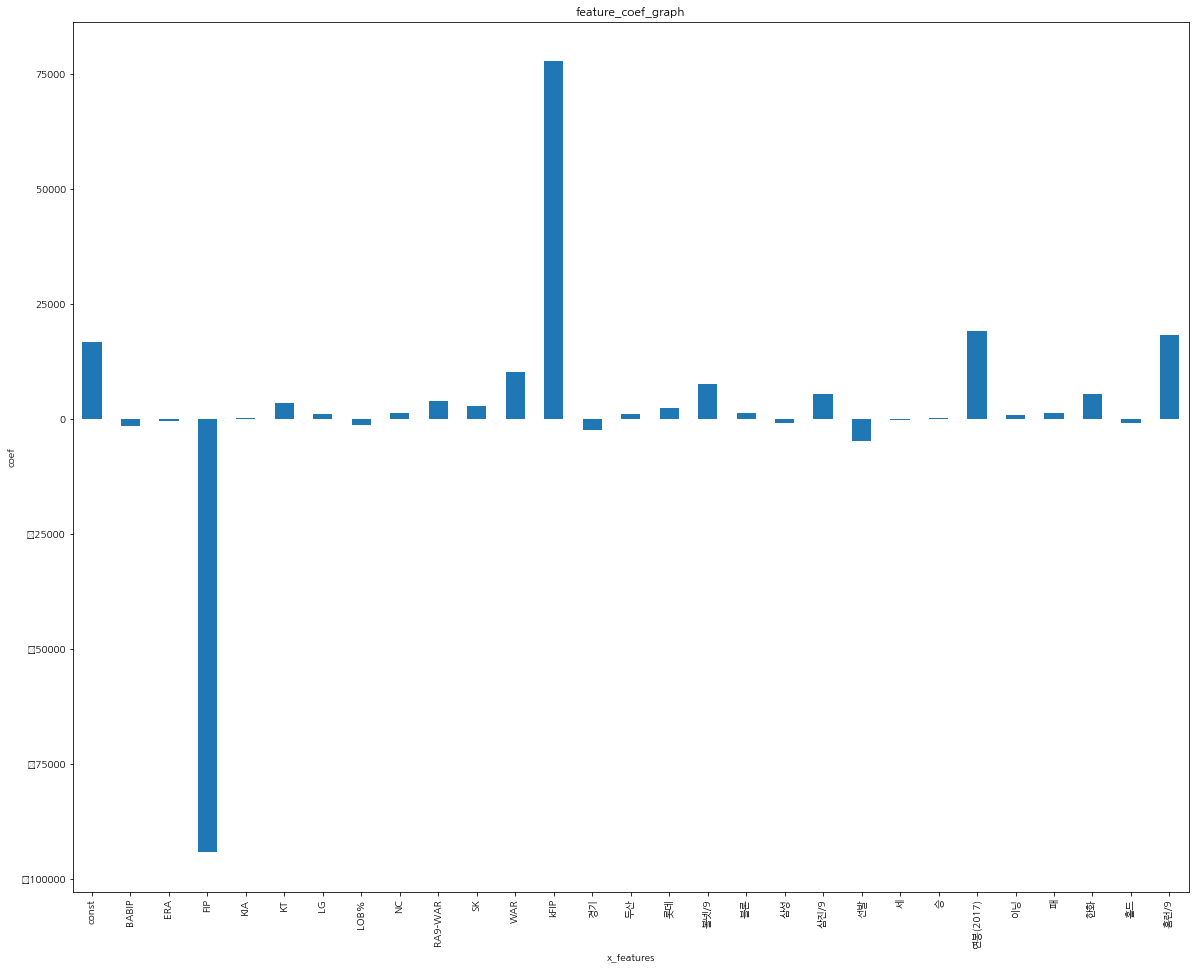

In [20]:
# 한글 출력을 위한 사전 설정
# mpl.rc('font',family='NanumGothicOTF')
# plt.rcParams['figure.figsize']=[20,16]

# 회귀 계수를 리스트로 반환
coefs=model.params.tolist()
coefs_series=pd.Series(coefs)

# 변수명을 리스트로 반환
x_labels = model.params.index.tolist()

# 회귀계수를 출력합니다.
ax=coefs_series.plot(kind='bar')
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

In [21]:
# FIP : 유의미한 피처 X 영향력이 큰 피처 O
# WAR : 유의미한 피처 O 영향력이 큰 피처 O
# 홈런 : 유의미한 피처 X 영향력이 큰 피처 O
# 작년 연봉 : 유의미한 피처 O 영향력은 O
# 팀(한화) : 유의미한 피처 O 영향력은 X

In [22]:
# 수정결정계수를 sklean의 LinearRegression 클래스로 출력
# 예측 모델 평가하기 : R2 Score
# 학습 데이터와 테스트 데이터로 분리합니다.
X = pitcher_df[pitcher_df.columns.difference(['선수명','y'])]
y = pitcher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=19)

# 회귀 분석 모델을 학습합니다. 
lr = linear_model.LinearRegression()
model=lr.fit(X_train, y_train)

# 회귀 분석 모델을 평가합니다.
print(model.score(X_train, y_train)) # train R2 score 을 학습합니다.
print(model.score(X_test, y_test)) # test R2 score 을 학습합니다.

0.9276949405576705
0.8860171644977818


In [23]:
# 두 점수는 최대한 벌어지지 않는 것이 좋다
# 학습 점수가 테스트 점수에 비해 높다면 -> 과적합

In [24]:
# 회귀 분석 모델을 평가합니다. ->RMSE score 측정 지표 활용
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score을 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score을 출력합니다.

7282.718684746374
14310.69643688913


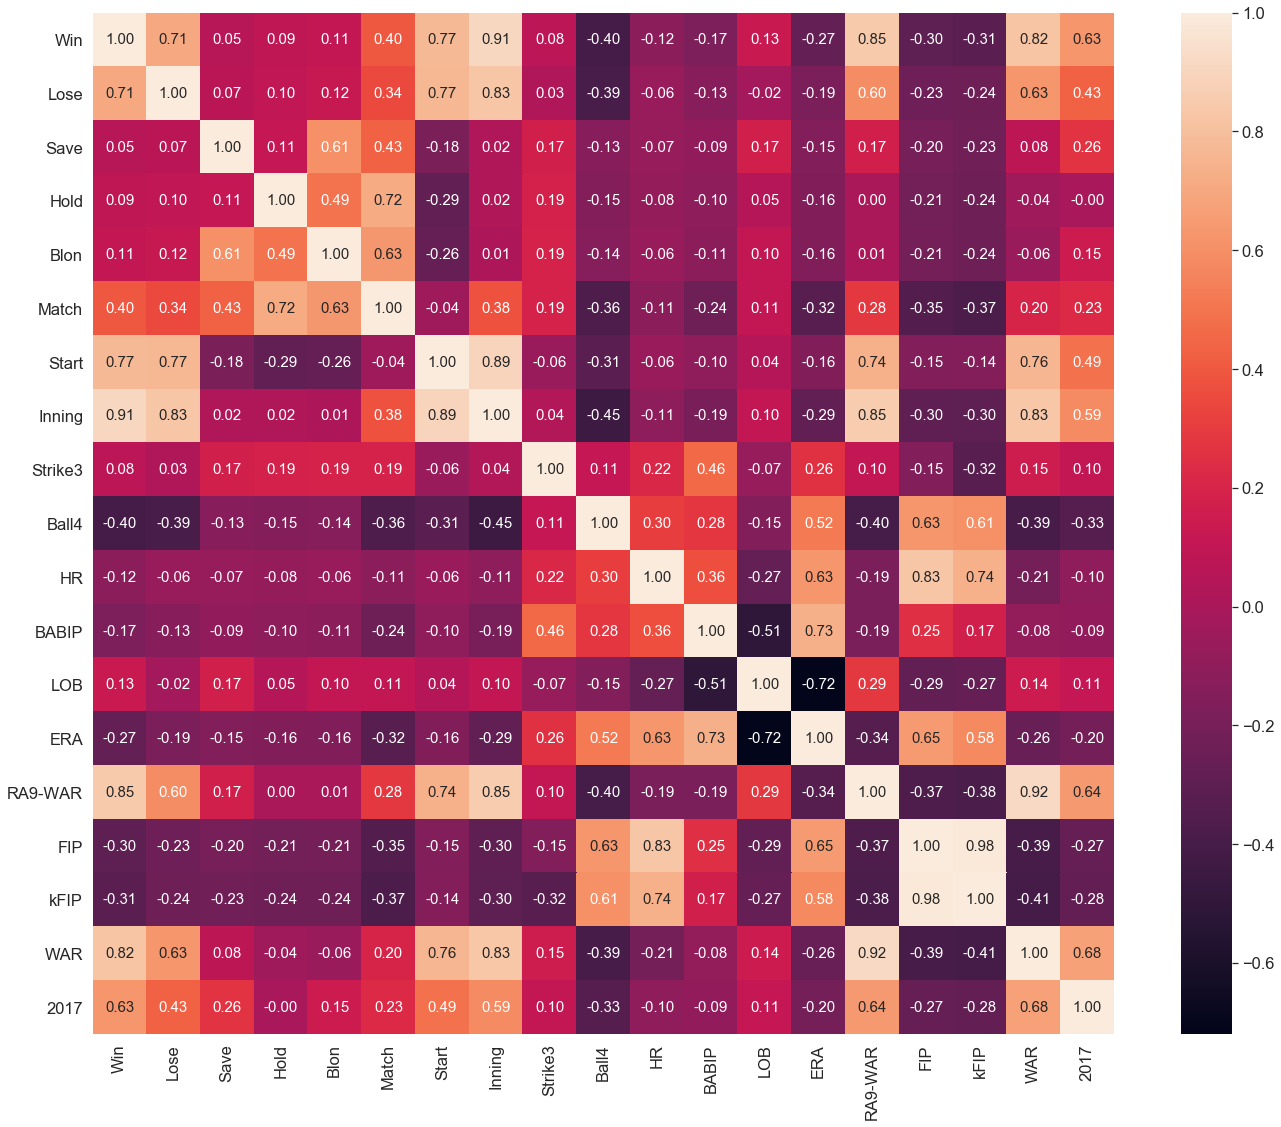

In [25]:
# heatmap 방식의 시각화 사용
# 승-이닝 kFIP-FIP RA9_WAR-WAR 에서 높은 연관성을 가진다
import seaborn as sns
# 피처 간의 상곽계수 행렬을 계산
corr=pitcher_df[scale_columns].corr(method='pearson')
show_cols=['Win', 'Lose','Save', 'Hold', 'Blon','Match', 'Start', 'Inning', 'Strike3', 'Ball4',
           'HR', 'BABIP','LOB','ERA','RA9-WAR','FIP','kFIP','WAR','2017']

#corr 행렬 히트맵을 시작합니다.
plt.rc('font',family='NanumGothicOTF')
sns.set(font_scale=1.5)
hm=sns.heatmap(corr.values,
              cbar=True,
              annot=True,
              square=True,
              fmt='.2f',
              annot_kws={'size': 15},
              yticklabels=show_cols,
              xticklabels=show_cols)

plt.tight_layout()
plt.show()

In [26]:
# 다중 공선성이란? 변수간 상관관계가 높아서 분석에 부정적인 영향을 미치는 것
# 분산팽창요인(VIF)라는 계수로 평가
# VIF 계수가 10~15 정도를 넘으면 다중공선성의 문제가 발생했다고 판단
# [variance_infaltion_factor(X.values,i)for i in range(X.shape[1])] -> 각 피처마다 적용

In [27]:
# 회귀분석예측 성능을 높이기 위한 방법 : 다중 공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 피처마다의 VIF계수를 출력합니다.
vif=pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values,i)
                     for i in range(X.shape[1])]
vif["features"]=X.columns
vif.round(1)

,VIF Factor,features
0,3.2,BABIP
1,10.6,ERA
2,14238.3,FIP
3,1.1,KIA
4,1.1,KT
5,1.1,LG
6,4.3,LOB%
7,1.1,NC
8,13.6,RA9-WAR
9,1.1,SK


In [28]:
# FIP(14238.3), kFIP(10264.1)와 같이 상호 연관성이 높은 피처들은 높은 VIF를 보인다.
# 이러한 요소들을 고려하여 사용할 피처들을 다시 선정 한 뒤 회귀분석 수행해봅시다.

In [36]:
# 피처 각각에 대한 스케일일을 수행하는 함수를 정의합니다.
# 피처를 재선정합니다.
X = pitcher_df[['FIP', 'WAR', '삼진/9', '연봉(2017)']]
y2 = pitcher_df['y']

X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=19)
lr = linear_model.LinearRegression()

model = lr.fit(X_train, y2_train)
predict_2018_salary = lr.predict(X)
pitcher_df['예측연봉(2018)'] = pd.Series(predict_2018_salary)

In [58]:
# 원래의 데이터 프레임을 다시 로드합니다.
pitcher = pd.read_csv(pitcher_file_path)
pitcher = pitcher[['팀명','선수명', '연봉(2017)']]

# 원래의 데이터 프레임에 2018년 연봉 정보를 합칩니다.
result_df = pitcher_df.sort_values(by=['y'], ascending=False)
result_df.drop(['연봉(2017)'], axis=1, inplace=True, errors='ignore')
result_df = result_df.merge(pitcher, on=['선수명'], how='left')
result_df = result_df[['팀명','선수명', 'y', '예측연봉(2018)', '연봉(2017)']]
result_df.columns = ['팀명', '선수명', '실제연봉(2018)', '예측연봉(2018)', '작년연봉(2017)']

# 재계약하여 연봉이 변화한 선수만을 대상으로 관찰합니다.
result_df = result_df[result_df['작년연봉(2017)'] != result_df['실제연봉(2018)']]
result_df = result_df[result_df['팀명'] == '두산']
result_df = result_df.reset_index()
result_df = result_df.iloc[:20, :]
result_df.head(20)

,index,팀명,선수명,실제연봉(2018),예측연봉(2018),작년연봉(2017)
0,39,두산,함덕주,16000,35441.698038,7000
1,43,두산,김강률,15000,14893.231052,6200
2,66,두산,홍상삼,9000,9603.699566,12500
3,97,두산,김명신,5200,6947.179136,2700
4,98,두산,이현호,5200,4337.812087,6000
5,104,두산,이영하,4200,1538.711140,2700
6,123,두산,박치국,3400,2511.728226,2700
7,125,두산,고봉재,3300,4962.434886,4400
8,135,두산,임진우,3000,2384.891807,3200


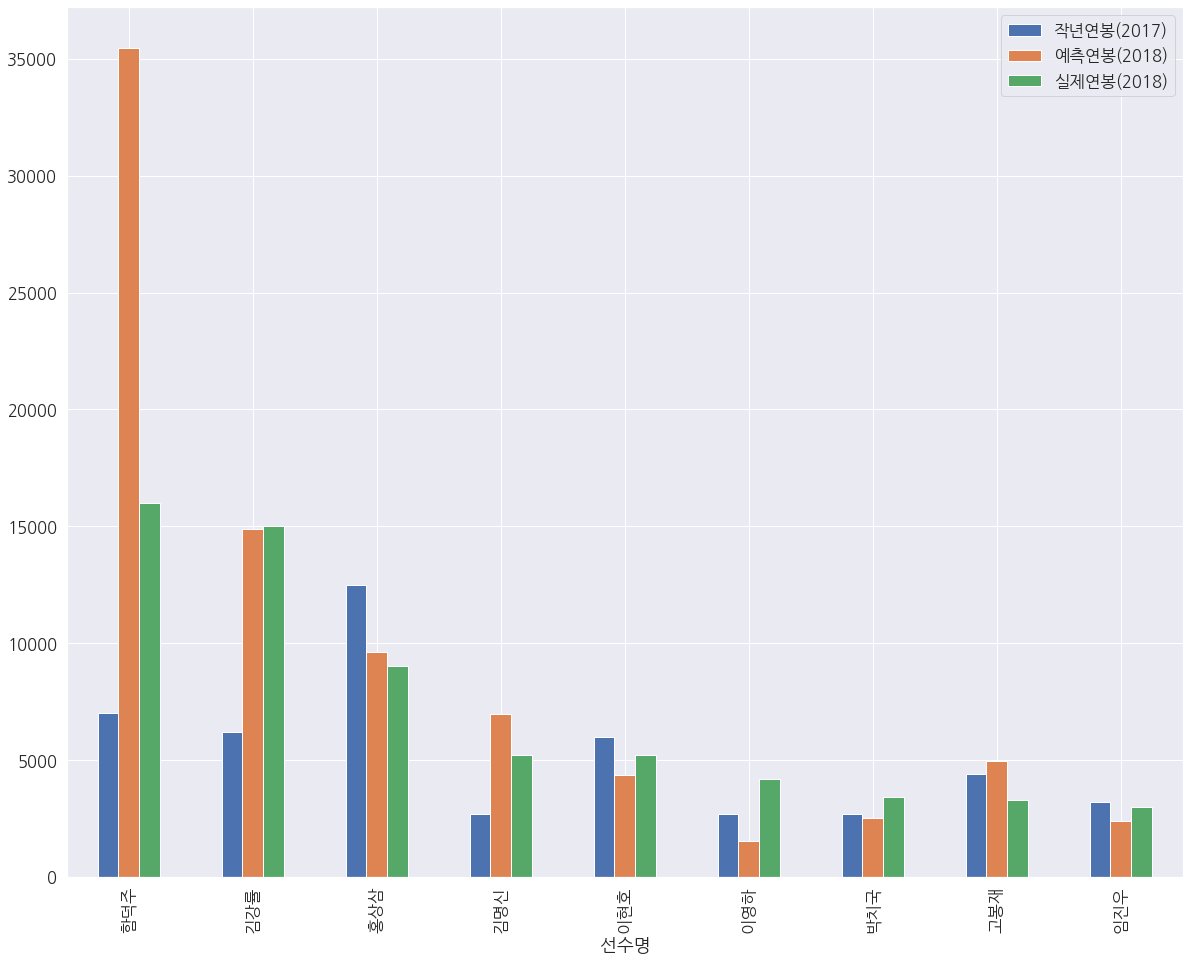

In [59]:
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)
result_df.plot(x='선수명', y=['작년연봉(2017)','예측연봉(2018)','실제연봉(2018)'],kind="bar")